In [1]:
import sys
sys.path.insert(0, '..')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from intransparent import (
    REPORTS_PER_PLATFORM,
    ingest_reports_per_platform,
    long_ncmec_reports,
    wide_ncmec_reports,
    compare_all_platform_reports,
    show,
)

In [2]:
PKGS = ["iccCounts", "dplyr", "ggplot2", "scales", "patchwork", "purrr", "svglite"]

path = Path("..") / "rlib"
path.mkdir(exist_ok=True)
RLIB = str(path)

%load_ext rpy2.ipython

import rpy2.robjects.packages as r_packages
from rpy2.robjects.vectors import StrVector

not_installed = [p for p in PKGS if not r_packages.isinstalled(p, lib_loc=RLIB)]
if not_installed:
    show(f"""
        <strong style='file-size: 1.2em'><em>
        Installing R package(s) {", ".join(not_installed)}. This may take a while...
        </em></strong>
    """)

    utils = r_packages.importr("utils")
    utils.chooseCRANmirror(ind=1)
    utils.install_packages(StrVector(not_installed), lib=RLIB)

In [3]:
show('<h1>CSAM Reports per Platform</h1>')
show('<h2>Ingesting Platform Disclosures</h2>')

def logger(format: str, *args, **kwargs) -> None:
    print(format.format(*args, **kwargs))

platform_data = ingest_reports_per_platform(REPORTS_PER_PLATFORM, logger=logger)

show('<h2>An Overview of Platform Disclosures</h2>')
show(platform_data.features, caption='Platforms and Their Disclosures')

Skipping metadata
➖ Alphabet (no CSAM data)
✅ Amazon
➖ Apple (no CSAM data)
➖ Automattic (no CSAM data)
➖ Aylo (no CSAM data)
✅ Discord
✅ Facebook
✅ GitHub
✅ Google
✅ Instagram
✅ LinkedIn
➖ Meta (no CSAM data)
✅ Microsoft
➖ MindGeek (no transparency disclosures)
➖ Omegle (no CSAM data)
✅ Pinterest
✅ Pornhub
➖ Quora (no CSAM data)
✅ Reddit
✅ Snap
➖ Telegram (no transparency disclosures)
✅ TikTok
✅ TikTok (original schema)
➖ Tumblr (no CSAM data)
✅ Twitch
✅ Twitter
➖ WhatsApp (no CSAM data)
➖ Wikimedia (no transparency disclosures)
➖ Wordpress (no CSAM data)
➖ X (no CSAM data)
✅ YouTube
✅ NCMEC


,data,history,terms,quantities,granularity,frequency,coverage,has_reports
platform,,,,,,,,
Alphabet,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Amazon,⋯,linked list of pages,CSAM,counts,Y,Y,2020,True
Apple,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Automattic,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Aylo,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Discord,csv,same page (dropdown),child safety; CSAM,counts,Q,Q,2020 H2,True
Facebook,csv,data,child nudity & sexual exploitation; child sexual exploitation,rounded,Q,Q,2018 Q3,False
GitHub,⋯,same page (dropdown),CSEAI,counts,Y,Y,2021,True
Google,⋯,same page (dropdown),CSAM,counts,H,H,2020 H1,True


In [4]:
show('<h2>Ranking of Social Media Firms</h2>')

ncmec = long_ncmec_reports(platform_data)
totals = ncmec[ncmec['platform'] == 'Total']['reports']

year = ncmec.index.min()
stop = ncmec.index.max()

while year <= stop:
    yearly = (
        ncmec.loc[year]
        .sort_values('reports', ascending=False)
        .assign(reports_pct=lambda df: df['reports'] / totals[year] * 100)
    )

    yearly.loc[yearly['platform'].isin(['ESP Total', 'Total']), 'reports_pct'] = np.NaN
    yearly['cumpct'] = yearly['reports_pct'].cumsum()

    show(
        yearly,
        caption=f' Social Media by CSAM Reports Filed in {year}',
    )
    year += 1

,platform,reports,reports_pct,cumpct
period,,,,
2019,Total,"16,987,361",⋯,⋯
2019,ESP Total,"16,836,694",⋯,⋯
2019,Meta,"15,884,511",93.50782031,93.5
2019,Alphabet,"449,283",2.64480751,96.2
2019,Microsoft,"123,929",0.72953651,96.9
2019,Snap,"82,030",0.48288843,97.4
2019,X,"45,726",0.26917660,97.6
2019,Discord,"19,480",0.11467349,97.7
2019,Automattic,"10,443",0.06147512,97.8


,platform,reports,reports_pct,cumpct
period,,,,
2020,Total,"21,751,085",⋯,⋯
2020,ESP Total,"21,447,786",⋯,⋯
2020,Meta,"20,307,216",93.36185298,93.4
2020,Alphabet,"546,704",2.51345623,95.9
2020,Snap,"144,095",0.66247270,96.5
2020,Microsoft,"96,838",0.44520997,97.0
2020,X,"65,062",0.29912071,97.3
2020,TikTok,"22,692",0.10432583,97.4
2020,Omegle,"20,265",0.09316777,97.5


,platform,reports,reports_pct,cumpct
period,,,,
2021,Total,"29,397,681",⋯,⋯
2021,ESP Total,"29,157,083",⋯,⋯
2021,Meta,"26,885,302",91.4538191,91.5
2021,Alphabet,"875,783",2.9790887,94.4
2021,Snap,"512,522",1.7434096,96.2
2021,TikTok,"154,618",0.5259531,96.7
2021,X,"86,666",0.2948056,97.0
2021,Microsoft,"78,887",0.2683443,97.3
2021,Omegle,"46,924",0.1596180,97.4


,platform,reports,reports_pct,cumpct
period,,,,
2022,Total,"32,059,029",⋯,⋯
2022,ESP Total,"31,802,525",⋯,⋯
2022,Meta,"27,190,665",84.8143748,84.8
2022,Alphabet,"2,174,548",6.7829503,91.6
2022,Omegle,"608,601",1.8983763,93.5
2022,Snap,"551,086",1.7189728,95.2
2022,TikTok,"288,125",0.8987328,96.1
2022,Discord,"169,800",0.5296480,96.6
2022,Microsoft,"108,804",0.3393864,97.0


,platform,reports,reports_pct,cumpct
period,,,,
2023,Total,"36,210,368",⋯,⋯
2023,ESP Total,"35,944,826",⋯,⋯
2023,Meta,"30,658,047",84.6664883,84.7
2023,Alphabet,"1,470,958",4.0622564,88.7
2023,X,"870,503",2.4040159,91.1
2023,Snap,"713,055",1.9692012,93.1
2023,TikTok,"590,376",1.6304060,94.7
2023,Discord,"339,412",0.9373337,95.7
2023,Reddit,"290,141",0.8012650,96.5


In [5]:
data = (
    # Select rows with actual platform data
    ncmec[~ncmec['platform'].isin(['Total', 'ESP Total'])]
    # Compute yearly report percentage
    .assign(reports_pct=lambda df: df['reports'] / df.groupby(df.index)['reports'].sum() * 100)
    # Sort in descending order
    .sort_values('reports_pct', ascending=False)
    # Drop the reports column
    .drop(columns=['reports'])
    # Select rows with more than one percent
    .query("reports_pct > 2.5")
)

missing = (100 - data.groupby(data.index)['reports_pct'].sum()).to_frame()
missing['platform'] = 'Others'

data = pd.concat([data, missing]).pivot(columns='platform', values='reports_pct').fillna(0.0)
#data = data[['Meta', 'Alphabet', 'X', 'Snap', 'Omegle', 'TikTok', 'Others']]
data = data[['Meta', 'Alphabet', 'Others']]
data = data.rename(columns={'Alphabet': 'Google'})

show(data)

platform,Meta,Google,Others
period,,,
2019,95.5,2.70,1.77
2020,95.6,2.57,1.86
2021,93.6,3.05,3.37
2022,86.7,6.93,6.35
2023,86.7,4.16,9.18


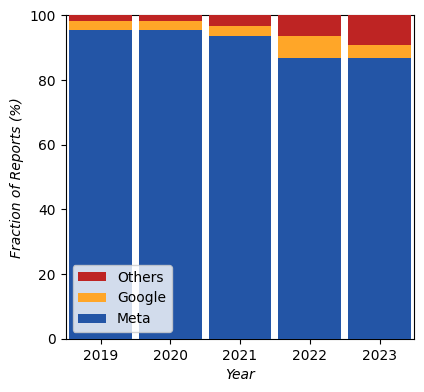

In [6]:
COLORS = ["#2355a6", "#ffa628", "#be2423", "#be2423"]

def plot(data, ax, colors):
    data.plot.bar(
        ax=ax,
        stacked=True,
        zorder=3,
        width=0.9,
        color = colors,
        figsize=[4.5, 4.2],
    )
    ax.set_xlim(-0.5, 4.5)
    ax.set_xlabel('Year', fontstyle='italic')
    ax.set_ylabel('Fraction of Reports (%)', fontstyle='italic')
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_ylim(top=100)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

fig, ax = plt.subplots()
plot(data, ax, COLORS)

fig.savefig('../figure/platforms-share.svg')

In [7]:
show('<h2>CyberTipline Report Counts per Service Provider</h2>')

# No piece counts are available for the rest of Microsoft in 2019.
# So we drop LinkedIn's data, which is in the noise already.
linkedin = platform_data.disclosures["LinkedIn"]
linkedin.loc[linkedin.index.year == 2019, "pieces"] = np.NaN
reddit = platform_data.disclosures["Reddit"]
reddit.loc[pd.Period("2023-01", freq="6M"), "pieces"] = np.NaN
github = platform_data.disclosures["GitHub"]
github.loc[github.index.year == 2023, "reports"] = np.NaN

comparisons = compare_all_platform_reports(platform_data)

from intransparent.platform.compare import compare_twitch
twitch = compare_twitch(platform_data)
comparisons['Twitch'] = twitch

comparisons['Google'] = comparisons['Alphabet']
del comparisons['Alphabet']

brand_holders = len(platform_data.brands)
brand_holder_brands = sum(len(brands) for brands in platform_data.brands.values())
# Account for '@' and 'NCMEC':
surveyed_brands = len(REPORTS_PER_PLATFORM) - 1 - 1 - brand_holders
surveyed_firms = surveyed_brands - brand_holder_brands + brand_holders
# Account for 'NCMEC':
brands_with_disclosures = len(
    set(platform_data.disclosures) - set(platform_data.brands)
) - 1

show(
    f"""
    Out of {surveyed_brands} surveyed social media platforms owned by
    {surveyed_firms} firms, {brands_with_disclosures} brands make transparency
    disclosures. Furthermore, only {len(comparisons)} platforms disclose usable
    piece or report counts.
    """
)

provider_names = sorted(comparisons)
for provider in provider_names:
    if provider == 'Twitch':
        caption = 'Twitch (Also Included with Amazon)'
    else:
        caption = provider
    show(comparisons[provider], caption=caption, min_precision=3)

,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,549,0.00326,"16,836,694",0.00323,"16,987,361",99.113
2020,⋯,⋯,"2,235",≡,"2,235",0.01042,"21,447,786",0.01028,"21,751,085",98.606
2021,"27,244",0.805,"33,848",-0.0443,"33,833",0.11604,"29,157,083",0.11509,"29,397,681",99.182
2022,"52,656",0.785,"67,073",4.4946,"70,157",0.22060,"31,802,525",0.21884,"32,059,029",99.200
2023,"24,756",0.791,"31,281",3.3878,"32,359",0.09002,"35,944,826",0.08936,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,205,0.001218,"16,836,694",0.001207,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,265,0.001236,"21,447,786",0.001218,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,160,0.000549,"29,157,083",0.000544,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,234,0.000736,"31,802,525",0.000730,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,267,0.000743,"35,944,826",0.000737,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"10,443",0.0620,"16,836,694",0.0615,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"9,130",0.0426,"21,447,786",0.0420,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"4,821",0.0165,"29,157,083",0.0164,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"5,035",0.0158,"31,802,525",0.0157,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"19,591",0.0545,"35,944,826",0.0541,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,⋯,⋯,"16,836,694",⋯,"16,987,361",99.113
2020,⋯,⋯,"4,171",104.115,"13,229",0.06168,"21,447,786",0.06082,"21,751,085",98.606
2021,"20,401",2.259,"9,029",0.816,"9,103",0.03122,"29,157,083",0.03097,"29,397,681",99.182
2022,"9,588",4.804,"1,996",4.840,"2,095",0.00659,"31,802,525",0.00653,"32,059,029",99.200
2023,"7,313",2.922,"2,503",3.648,"2,596",0.00722,"35,944,826",0.00717,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"19,480",0.1157,"16,836,694",0.1147,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"15,324",0.0714,"21,447,786",0.0705,"21,751,085",98.606
2021,⋯,⋯,"24,623",18.378,"29,606",0.1015,"29,157,083",0.1007,"29,397,681",99.182
2022,⋯,⋯,"58,179",97.922,"169,800",0.5339,"31,802,525",0.5296,"32,059,029",99.200
2023,⋯,⋯,"164,478",69.433,"339,412",0.9443,"35,944,826",0.9373,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"449,283",2.668,"16,836,694",2.645,"16,987,361",99.113
2020,"4,437,853",8.100,"547,875",-0.2140,"546,704",2.549,"21,447,786",2.513,"21,751,085",98.606
2021,"6,696,497",7.694,"870,319",0.6259,"875,783",3.004,"29,157,083",2.979,"29,397,681",99.182
2022,"13,402,885",6.164,"2,174,319",0.0105,"2,174,548",6.838,"31,802,525",6.783,"32,059,029",99.200
2023,"7,955,169",5.404,"1,472,221",-0.0858,"1,470,958",4.092,"35,944,826",4.062,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,"37,400,000",2.354,⋯,⋯,"15,884,511",94.345,"16,836,694",93.508,"16,987,361",99.113
2020,"38,890,800",1.915,⋯,⋯,"20,307,216",94.682,"21,447,786",93.362,"21,751,085",98.606
2021,"78,012,400",2.902,⋯,⋯,"26,885,302",92.208,"29,157,083",91.454,"29,397,681",99.182
2022,"105,800,000",3.891,⋯,⋯,"27,190,665",85.498,"31,802,525",84.814,"32,059,029",99.200
2023,"63,300,000",2.065,⋯,⋯,"30,658,047",85.292,"35,944,826",84.666,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"123,929",0.736,"16,836,694",0.730,"16,987,361",99.113
2020,"1,256,449.000",13.029,"96,435.000",0.4170,"96,838",0.452,"21,447,786",0.445,"21,751,085",98.606
2021,"564,157.000",7.148,"78,930.000",-0.0545,"78,887",0.271,"29,157,083",0.268,"29,397,681",99.182
2022,"450,447.000",4.186,"107,605.000",1.1081,"108,804",0.342,"31,802,525",0.339,"32,059,029",99.200
2023,"402,630.000",2.861,"140,720.000",0.3667,"141,237",0.393,"35,944,826",0.390,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"3,470",0.0206,"16,836,694",0.0204,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"20,265",0.0945,"21,447,786",0.0932,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"46,924",0.1609,"29,157,083",0.1596,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"608,601",1.9137,"31,802,525",1.8984,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"188,102",0.5233,"35,944,826",0.5195,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"7,360",0.04371,"16,836,694",0.04333,"16,987,361",99.113
2020,⋯,⋯,"3,432",≡,"3,432",0.01600,"21,447,786",0.01578,"21,751,085",98.606
2021,"1,608",0.599,"2,684",-16.147,"2,283",0.00783,"29,157,083",0.00777,"29,397,681",99.182
2022,"37,136",1.127,"32,964",4.002,"34,310",0.10788,"31,802,525",0.10702,"32,059,029",99.200
2023,"57,774",1.145,"50,437",3.734,"52,356",0.14566,"35,944,826",0.14459,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,1,0.00000594,"16,836,694",0.00000589,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,2,0.00000932,"21,447,786",0.00000919,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,25,0.00008574,"29,157,083",0.00008504,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"2,242",0.00704975,"31,802,525",0.00699335,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"6,135",0.01706783,"35,944,826",0.01694266,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,724,≡,724,0.00430,"16,836,694",0.00426,"16,987,361",99.113
2020,⋯,⋯,"2,233",≡,"2,233",0.01041,"21,447,786",0.01027,"21,751,085",98.606
2021,"9,258",0.920,"10,059",≡,"10,059",0.03450,"29,157,083",0.03422,"29,397,681",99.182
2022,"80,888",1.538,"52,592",≡,"52,592",0.16537,"31,802,525",0.16405,"32,059,029",99.200
2023,⋯,⋯,"290,121",0.00689,"290,141",0.80718,"35,944,826",0.80126,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"82,030",0.487,"16,836,694",0.483,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"144,095",0.672,"21,447,786",0.662,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"512,522",1.758,"29,157,083",1.743,"29,397,681",99.182
2022,"1,273,838",2.313,"550,755",0.0601,"551,086",1.733,"31,802,525",1.719,"32,059,029",99.200
2023,"1,594,805",2.307,"691,225",3.1091,"713,055",1.984,"35,944,826",1.969,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,596,0.00354,"16,836,694",0.00351,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"22,692",0.10580,"21,447,786",0.10433,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"154,618",0.53029,"29,157,083",0.52595,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"288,125",0.90598,"31,802,525",0.89873,"32,059,029",99.200
2023,"107,418,328.116",181.949,⋯,⋯,"590,376",1.64245,"35,944,826",1.63041,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
year,,,,,,,,,,
2020,⋯,⋯,"2,158",⋯,⋯,0.0101,"21,447,786",0.00992,"21,751,085",98.606
2021,⋯,⋯,"6,621",0.121,"6,629",0.0227,"29,157,083",0.02255,"29,397,681",99.182
2022,⋯,⋯,"14,296",1.472,"14,508",0.0456,"31,802,525",0.04525,"32,059,029",99.200


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,13,0.0000772,"16,836,694",0.0000765,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,11,0.0000513,"21,447,786",0.0000506,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,8,0.0000274,"29,157,083",0.0000272,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,29,0.0000912,"31,802,525",0.0000905,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,34,0.0000946,"35,944,826",0.0000939,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"45,726",0.272,"16,836,694",0.269,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"65,062",0.303,"21,447,786",0.299,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"86,666",0.297,"29,157,083",0.295,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"98,050",0.308,"31,802,525",0.306,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"870,503",2.422,"35,944,826",2.404,"36,210,368",99.267


In [8]:
show("<em style='font-size: 1.2em'>Building long data frame with comparable reports...</em>")

comparable_reports = None
for provider in provider_names:
    if provider == "Twitch":
        continue

    # We are only interested in years with report counts for platform and NCMEC
    data = comparisons[provider][["reports", "NCMEC"]]
    data = data[data["reports"].notna() & data["NCMEC"].notna()]
    if len(data) == 0:
        continue

    # Reshape as long frame with year, observer, count, and topic columns
    data = (data
        .assign(year=data.index.year)
        .reset_index(drop=True)
        .rename(columns={"reports": provider})
        .melt(id_vars="year", value_vars=["year", provider, "NCMEC"])
        .rename(columns={"variable": "observer", "value": "count"})
        .assign(topic=provider)
        .assign(count=lambda df: df["count"].astype("int64"))
    )

    if comparable_reports is None:
        comparable_reports = data
    else:
        comparable_reports = pd.concat([comparable_reports, data])

# The index repeats the same counts over and over again for each provider
comparable_reports = comparable_reports.reset_index(drop=True)
comparable_reports.to_csv("../data/comparable-reports-by-provider.csv", index=False)

show("<em style='font-size: 1.2em'>Erasing service provider identities from comparable reports...</em>")

cp = comparable_reports
cp.loc[cp["observer"] != "NCMEC", "observer"] = "ServiceProvider"
cp["id"] = cp["topic"].astype(str) + cp["year"].astype(str)
cp = cp[["id", "observer", "count"]]
cp.to_csv("../data/comparable-reports.csv", index=False)

show("<h2>Bland-Altman Plots for Comparable Report Counts</h2>")

[1] "----------------------------------------------------------------------------"
[1] "Processing Amazon"
[1] "----------------------------------------------------------------------------"
[1] "Processing Aylo"
[1] "----------------------------------------------------------------------------"
[1] "Processing Discord"
[1] "----------------------------------------------------------------------------"
[1] "Processing Google"
[1] "----------------------------------------------------------------------------"
[1] "Processing Microsoft"
[1] "----------------------------------------------------------------------------"
[1] "Processing Pinterest"
[1] "----------------------------------------------------------------------------"
[1] "Processing Reddit"
[1] "----------------------------------------------------------------------------"
[1] "Processing Snap"
[1] "----------------------------------------------------------------------------"



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Need help getting started? Try the R Graphics Cookbook:
https://r-graphics.org

Attaching package: ‘purrr’

The following object is masked from ‘package:scales’:

    discard



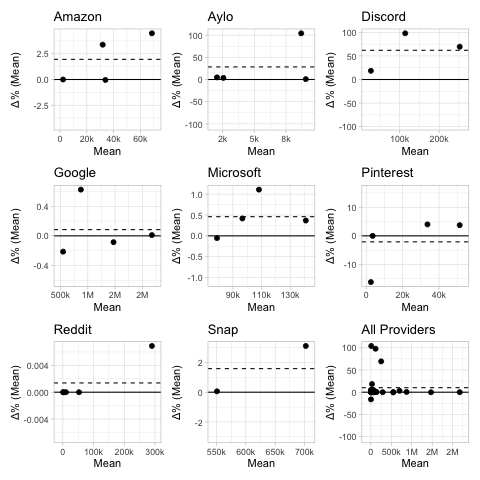

In [9]:
%%R -i RLIB

.libPaths(RLIB)

library(dplyr)
library(ggplot2)
library(patchwork)
library(scales)
library(purrr)

data_path <- function(csv_name) {
  return(normalizePath(sprintf("../data/%s.csv", csv_name)))
}

format_mean_zero <- number_format()
format_mean_kilo <- number_format(scale=0.001, suffix="k")
format_mean_mega <- number_format(scale=0.000001, suffix="M")
format_mean <- function(x) {
  dplyr::case_when(
    is.na(x) ~ "",
    x == 0 ~ format_mean_zero(x),
    x < 1000000 ~ format_mean_kilo(x),
    TRUE ~ format_mean_mega(x)
  )
}

format_all_means <- function(xs) map(xs, format_mean)

plot_percent_diff_over_mean <- function(data, title) {
  data <- data |>
    group_by(id) |>
    summarize(Mean = mean(count), Diff = combn(count, diff, m=2)) |>
    mutate(PctDiff = Diff / Mean * 100)

  ymax <- max(abs(data$PctDiff))
  ymean <- mean(data$PctDiff)
  xmax <- max(data$Mean)
  xmin <- min(data$Mean)
  xrange <- xmax - xmin

  graph <- ggplot(data = data, aes(x=Mean,y=(PctDiff))) +
    geom_point(size=2) +
    xlim(xmin - 0.05 * xrange, xmax + 0.05 * xrange) +
    ylim(ymax * (-1), ymax) +
    geom_hline(yintercept = 0) +
    geom_hline(yintercept = ymean, linetype = "dashed") +
    xlab("Mean") +
    ylab("Δ% (Mean)") +
    labs(title = title)

  graph$scales$scales[[1]]$labels <- format_all_means
  graph$scales$scales[[2]]$labels <- comma_format()

  graph <- graph + theme_light() #linedraw()
  return(graph)
}

per_provider_data <- read.csv(data_path("comparable-reports-by-provider"))
providers <- unique(per_provider_data$topic)
ba_plots <- vector("list", length(providers) + 1)

index <- 0
for (provider in providers) {
  index <- index + 1

  print("----------------------------------------------------------------------------")
  print(sprintf("Processing %s", provider))
  provider.data <- per_provider_data |>
    filter(topic == provider) |>
    rename(id = year)
  ba_plots[[index]] <- plot_percent_diff_over_mean(provider.data, provider)
}

print("----------------------------------------------------------------------------")
all_data <- read.csv(data_path("comparable-reports"))
ba_plots[[length(providers) + 1]] <- plot_percent_diff_over_mean(
  all_data,
  "All Providers"
)

# Combine plots into 3x3 grid and display grid
grid <- wrap_plots(ba_plots, ncol=3)
print(grid)
ggsave("../figure/comparable-reports.svg", grid, width=7, height=7)

In [10]:
# In descending order of report counts for 2023:
COLOR_BREWER = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]

COLOR_GRIMM = [
    "#153dff",
    "#b32322",
    "#22a424",
    "#8727c0",
    "#824a01",
    "#0f6b94",
    "#a80590",
    "#69534f",
    "#545ba1",
    "#a04309",
    "#2d761d",
    "#0e70c7",
    "#b12145",
    "#6d48b6",
]

COLOR_OBSERVABLE = [
  "#4269d0", # blue
  "#efb118", # orange
  "#ff725c", # red
  "#6cc5b0", # cyan
  "#3ca951", # green
  "#ff8ab7", # pink
  "#a463f2", # purple
  "#97bbf5", # light blue
  "#9c6b4e", # brown
  "#9498a0", # gray
]

COLOR_GRIMM_OBSERVABLE = [
    # "#2b51c1", # blue
    # "#e18101", # orange
    # "#d6402c", # red
    # "#0aa78d", # cyan
    # "#e05f95", # pink
    # "#069335", # green
    # "#874bcb", # purple
    # "#5889d7", # light blue
    # "#8c5332", # brown
    # "#6c717d", # gray
    "#2b51c1", # blue
    "#e18101", # orange
    "#d6402c", # red
    "#0aa78d", # cyan
    "#874bcb", # purple
    "#069335", # green
    "#e05f95", # pink
    "#5889d7", # light blue
    "#8c5332", # brown
    "#6c717d", # gray
]

<Axes: xlabel='Year', ylabel='Reports'>

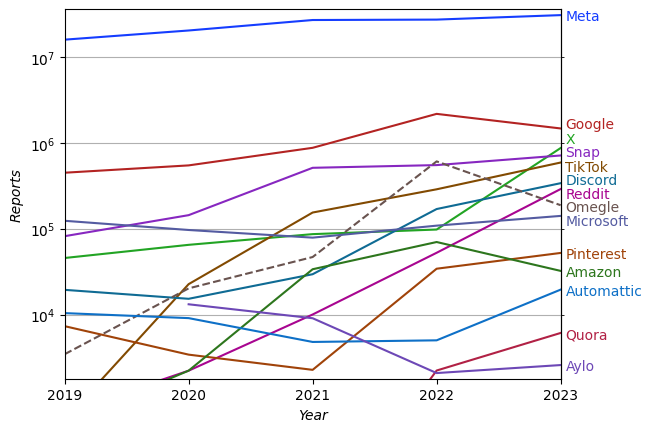

In [11]:
import math
import matplotlib as mp
import matplotlib.pyplot as plt

# Currently unused:
def mega_tick(y: int | float, _pos: object) -> str:
    if y == 0:
        return "0"
    if y % 1_000_000 == 0:
        return format(int(y) // 1_000_000, ",") + "M"
    return format(int(y) / 1_000_000, ",") + "M"

ncmec = wide_ncmec_reports(platform_data).rename(columns={"Alphabet": "Google"})

OFFSETS = {
    "Meta": 0,
    "Google": 4,
    "X": 7.5,
    "Snap": 3.5,
    "TikTok": -2,
    "Discord": 3,
    "Reddit": -2.5,
    "Omegle": 0,
    "Microsoft": -2.5,
    "Pinterest": 0,
    "Amazon": 0,
    "Automattic": 0,
    "Quora": 0,
    "Aylo": 0,
}

ALL_PLATFORMS = list(OFFSETS.keys())

def plot(ax, platforms, colors, dash_omegle=False):
    settings = { p: (OFFSETS[p], c) for p, c in zip(platforms, colors)}

    ncmec[platforms].plot(ax=ax)

    ax.set_title(None)
    ax.legend().remove()
    ax.set_xlabel("Year", fontstyle="italic")
    # ax.get_yaxis().set_major_formatter(mp.ticker.FuncFormatter(mega_tick))
    ax.set_ylabel("Reports", fontstyle="italic")
    ax.grid(axis="y")
    ax.set_ylim(1800, 36_000_000)
    ax.set_yscale("symlog")

    positions = [ncmec.loc["2023", p] for p in platforms]
    alt = ax.secondary_yaxis(location="right")
    alt.set_ylim(1800, 36_000_000)
    alt.set_yscale("symlog")
    alt.set_yticks(positions, labels=platforms)
    alt.tick_params(axis="y", length=0)

    for platform, line, label in zip(platforms, ax.get_lines(), alt.get_yticklabels()):
        raw_offset, color = settings[platform]

        line.set_color(color)
        if platform == "Omegle" and dash_omegle:
            line.set_linestyle("dashed")
        label.set_color(color)

        if raw_offset != 0:
            offset = mp.transforms.ScaledTranslation(
                0, raw_offset/72, ax.figure.dpi_scale_trans
            )
            label.set_transform(label.get_transform() + offset)

    return ax

fig, ax = plt.subplots()
plot(ax, ALL_PLATFORMS, COLOR_GRIMM, dash_omegle=True)

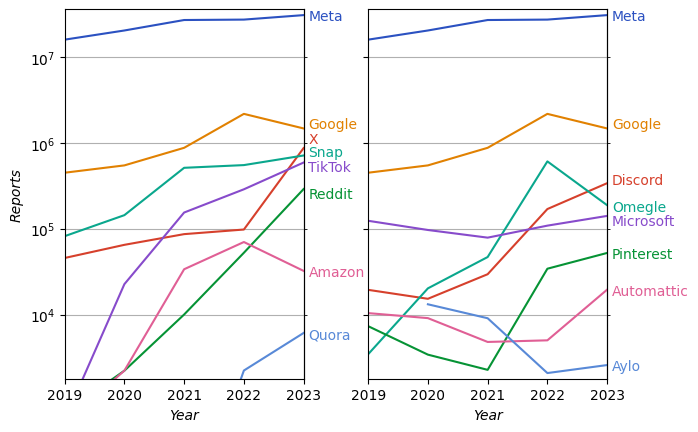

In [12]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=[7, 4.8],
    gridspec_kw=dict(wspace=0.27),
)

P1 = ['Meta', 'Google', 'X', 'Snap', 'TikTok', 'Reddit', 'Amazon', 'Quora']
P2 = ['Meta', 'Google', 'Discord', 'Omegle', 'Microsoft', 'Pinterest', 'Automattic', 'Aylo']

plot(ax1, P1, COLOR_GRIMM_OBSERVABLE)
plot(ax2, P2, COLOR_GRIMM_OBSERVABLE)
ax2.set_ylabel(None)
ax2.tick_params(labelleft=False)
fig.savefig("../figure/platforms.svg", bbox_inches='tight')